In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
# from torchvision.transforms import ToTensor, ToPILImage
import torchvision.transforms as transforms
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torchvision.models as models

In [2]:
sem_df=pd.read_excel("SEM_Final.xlsx")
print(sem_df.shape)
sem_df.head()

(1603, 15)


,link,title,num,letter,hydrogel,sentence,figure,SEM,SEM_img,scale,modulus,measurement,modification,skip,Unnamed: 14
0,https://pubs.acs.org/doi/10.1021/acsami.5b00184,Tough and Biocompatible Hydrogels Based on in ...,S3.,a,PVA,SEM images of the dehydrated PVA,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM3.jpg,-5.0,compressive,42.3 kPa,NaN,NaN,NaN
1,https://pubs.acs.org/doi/10.1021/acsami.5b00185,Tough and Biocompatible Hydrogels Based on in ...,S3.,a,PVA,SEM images of the dehydrated PVA,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM5.jpg,-6.0,compressive,42.3 kPa,NaN,NaN,NaN
2,https://pubs.acs.org/doi/10.1021/acsami.5b00186,Tough and Biocompatible Hydrogels Based on in ...,S3.,b,E-cGO0.5/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM1.jpg,-5.0,compressive,60 kPa,NaN,NaN,NaN
3,https://pubs.acs.org/doi/10.1021/acsami.5b00187,Tough and Biocompatible Hydrogels Based on in ...,S3.,b,E-cGO0.5/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM0.jpg,-6.0,compressive,60 kPa,NaN,NaN,NaN
4,https://pubs.acs.org/doi/10.1021/acsami.5b00188,Tough and Biocompatible Hydrogels Based on in ...,S3.,c,E-cGO1.0/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM6.jpg,-5.0,compressive,60 kPa,NaN,NaN,NaN


In [3]:
sem_df.isna().sum()

link               0
title              0
num                0
letter             4
hydrogel           0
sentence          16
figure             0
SEM                0
SEM_img          746
scale            743
modulus          766
measurement      772
modification    1603
skip             796
Unnamed: 14     1414
dtype: int64

In [4]:
measure_sem_df = sem_df[sem_df['skip'].isna()]
measure_sem_df = measure_sem_df[measure_sem_df['measurement'].isna()]
print(measure_sem_df.shape)
measure_sem_df.to_csv("missing_measurement.csv")
measure_sem_df.head()

(0, 15)


,link,title,num,letter,hydrogel,sentence,figure,SEM,SEM_img,scale,modulus,measurement,modification,skip,Unnamed: 14


In [5]:
parsed_sem_df = sem_df[sem_df['measurement'].notna()]
parsed_sem_df = parsed_sem_df[parsed_sem_df['SEM_img'].notna()]
print(parsed_sem_df['skip'].isna().sum())
parsed_sem_df = parsed_sem_df[parsed_sem_df['skip'].isna()]
print(parsed_sem_df.shape)
parsed_sem_df.head()

793
(793, 15)


,link,title,num,letter,hydrogel,sentence,figure,SEM,SEM_img,scale,modulus,measurement,modification,skip,Unnamed: 14
0,https://pubs.acs.org/doi/10.1021/acsami.5b00184,Tough and Biocompatible Hydrogels Based on in ...,S3.,a,PVA,SEM images of the dehydrated PVA,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM3.jpg,-5.0,compressive,42.3 kPa,NaN,NaN,NaN
1,https://pubs.acs.org/doi/10.1021/acsami.5b00185,Tough and Biocompatible Hydrogels Based on in ...,S3.,a,PVA,SEM images of the dehydrated PVA,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM5.jpg,-6.0,compressive,42.3 kPa,NaN,NaN,NaN
2,https://pubs.acs.org/doi/10.1021/acsami.5b00186,Tough and Biocompatible Hydrogels Based on in ...,S3.,b,E-cGO0.5/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM1.jpg,-5.0,compressive,60 kPa,NaN,NaN,NaN
3,https://pubs.acs.org/doi/10.1021/acsami.5b00187,Tough and Biocompatible Hydrogels Based on in ...,S3.,b,E-cGO0.5/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM0.jpg,-6.0,compressive,60 kPa,NaN,NaN,NaN
4,https://pubs.acs.org/doi/10.1021/acsami.5b00188,Tough and Biocompatible Hydrogels Based on in ...,S3.,c,E-cGO1.0/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM6.jpg,-5.0,compressive,60 kPa,NaN,NaN,NaN


In [6]:
parsed_sem_df['skip'].value_counts()

Series([], Name: skip, dtype: int64)

In [7]:
parsed_sem_df.isna().sum()

link              0
title             0
num               0
letter            4
hydrogel          0
sentence          8
figure            0
SEM               0
SEM_img           0
scale             4
modulus           0
measurement       0
modification    793
skip            793
Unnamed: 14     712
dtype: int64

In [8]:
missing_sem_df = parsed_sem_df[parsed_sem_df['SEM_img'].isna()]
# missing_sem_df.to_csv("missing_sem_rows.csv")
missing_sem_df.head(40) 

,link,title,num,letter,hydrogel,sentence,figure,SEM,SEM_img,scale,modulus,measurement,modification,skip,Unnamed: 14


In [9]:
missing_sem_df['skip'].value_counts()

Series([], Name: skip, dtype: int64)

In [10]:
parsed_sem_df['img_path'] = parsed_sem_df.apply(lambda x: os.path.join(x['SEM'],x['SEM_img']),axis=1)

In [11]:
parsed_sem_df['img_path']

0          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM3.jpg
1          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM5.jpg
2          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM1.jpg
3          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM0.jpg
4          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM6.jpg
                              ...                        
1598    sem/10.1021_acs.langmuir.8b02918\SEM\la-2018-0...
1599    sem/10.1021_acs.langmuir.8b02918\SEM\la-2018-0...
1600    sem/10.1021_acsbiomaterials.0c00143\SEM\ab0c00...
1601    sem/10.1021_acsbiomaterials.0c00143\SEM\ab0c00...
1602    sem/10.1021_acsbiomaterials.0c00143\SEM\ab0c00...
Name: img_path, Length: 793, dtype: object

In [12]:
# clean dataset to get correct labels
parsed_sem_df['measurement']

def convert_measurement(string):
    string.replace(" ","")
    kpa = ["KPa","kPa", "Kpa", "kpa","KpA"]
    mpa = ["Mpa","MPa"]
    gpa = ["GPa","Gpa"]
    
    if any(KPA in string for KPA in kpa):
        for KPA in kpa:
            string = string.replace(KPA,"")
        string = string.strip()
        value = float(string)
        value *= 1000 
    elif any(MPA in string for MPA in mpa):
        for MPA in mpa:
            string = string.replace(MPA,"")
        string = string.strip()
        value = float(string)
        value *= 1000000
    elif any(GPA in string for GPA in gpa):
        for GPA in gpa:
            string = string.replace(GPA,"")
        string = string.strip()
        value = float(string)
        value *= 1000000000
    elif "Pa" in string:
        string = string.replace("Pa","")
        string = string.strip()
        value = float(string)
    else:
        print(string)
        return
    return value
parsed_sem_df['measurement'].apply(convert_measurement)

0        42300.0
1        42300.0
2        60000.0
3        60000.0
4        60000.0
          ...   
1598    157000.0
1599    162000.0
1600      8000.0
1601     50000.0
1602    120000.0
Name: measurement, Length: 793, dtype: float64

In [13]:
transform = transforms.Compose(
    [transforms.Resize(256),
#     transforms.Grayscale(3),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
    ]
)
eval_transform = transform = transforms.Compose(
    [transforms.Resize(256),
#     transforms.Grayscale(3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
    ]
)

793
(793, 16)
Length: 793


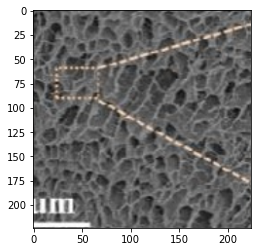

In [14]:
class semDataset(Dataset):
    def __init__(self,filepath="SEM_Final.xlsx", transform = None):
        sem_df=pd.read_excel("SEM_Final.xlsx")
        parsed_sem_df = sem_df[sem_df['measurement'].notna()]
        parsed_sem_df = parsed_sem_df[parsed_sem_df['SEM_img'].notna()]
        print(parsed_sem_df['skip'].isna().sum())
        parsed_sem_df = parsed_sem_df[parsed_sem_df['skip'].isna()]
        parsed_sem_df['img_path'] = parsed_sem_df.apply(lambda x: os.path.join(x['SEM'],x['SEM_img']),axis=1)
        print(parsed_sem_df.shape)
        parsed_sem_df['measurement']= parsed_sem_df['measurement'].apply(self.convert_measurement)
        self.sem_df = parsed_sem_df
        self.transform = transform
    
    def __len__(self):
        return parsed_sem_df.shape[0]
    
    def convert_measurement(self,string):
        string.replace(" ","")
        kpa = ["KPa","kPa", "Kpa", "kpa","KpA"]
        mpa = ["Mpa","MPa"]
        gpa = ["GPa","Gpa"]

        if any(KPA in string for KPA in kpa):
            for KPA in kpa:
                string = string.replace(KPA,"")
            string = string.strip()
            value = float(string)
            value *= 1000 
        elif any(MPA in string for MPA in mpa):
            for MPA in mpa:
                string = string.replace(MPA,"")
            string = string.strip()
            value = float(string)
            value *= 1000000
        elif any(GPA in string for GPA in gpa):
            for GPA in gpa:
                string = string.replace(GPA,"")
            string = string.strip()
            value = float(string)
            value *= 1000000000
        elif "Pa" in string:
            string = string.replace("Pa","")
            string = string.strip()
            value = float(string)
        else:
            print(string)
            return
        return np.log10(value)
    def __getitem__(self,index):
        image = Image.open(self.sem_df.iloc[index]["img_path"])
        label = self.sem_df.iloc[index]["measurement"]
        if self.transform is not None:
            image = self.transform(image)
        label = torch.tensor(label)
        return image, label
semdata = semDataset(transform=transform)
print(f"Length: {len(semdata)}")
image, label=semdata.__getitem__(0)
plt.imshow(image.permute(1,2,0))

In [15]:
# Create train test split, as 60/20/20 split
train_idx, test_idx = train_test_split(list(range(len(semdata))),test_size = 0.2, random_state=42)
train_idx, val_idx =  train_test_split(train_idx, test_size = 0.25, random_state=42)
train_data = torch.utils.data.Subset(semDataset(transform=transform),train_idx)
val_data = torch.utils.data.Subset(semDataset(transform=eval_transform),val_idx)
test_data = torch.utils.data.Subset(semDataset(transform=eval_transform),test_idx)
print(f"Train dataset length: {len(train_data)}")
print(f"Validation dataset length: {len(val_data)}")
print(f"Test dataset length: {len(test_data)}")

793
(793, 16)
793
(793, 16)
793
(793, 16)
Train dataset length: 475
Validation dataset length: 159
Test dataset length: 159


In [16]:
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          shuffle=True, num_workers=0, persistent_workers=False)
val_loader = DataLoader(val_data, batch_size=batch_size*4, 
                          shuffle=False, num_workers=0, persistent_workers=False)
test_loader = DataLoader(test_data, batch_size=batch_size*4, 
                          shuffle=False, num_workers=0, persistent_workers=False)

In [17]:
resolution = []
cannot_open = []
low_res = []
to_pil = transforms.ToPILImage()
for i in range(len(semdata)):
    try:
        image, label=semdata.__getitem__(i)
#         image = image.permute(1,2,0)
        image = to_pil(image)
        if image.size[0]<128 or image.size[1]<128:
            low_res.append(i)
        resolution.append(image.size)
    except:
        print(parsed_sem_df.iloc[i,:]["img_path"])
        cannot_open.append(i)
        print(f"Cannot open {i}")
parsed_sem_df.iloc[cannot_open,:].to_csv("cannot_open.csv")
print(f"We cannot open {len(cannot_open)} files")
print(f"Smallest resolution is {min(resolution)}")
print(f"Largest resolution is {max(resolution)}")

We cannot open 0 files
Smallest resolution is (224, 224)
Largest resolution is (224, 224)


In [18]:
low_res

[]

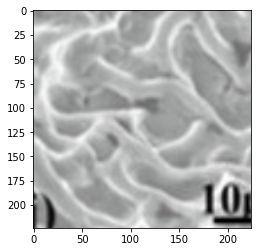

In [19]:
plt.imshow(semdata.__getitem__(615)[0].permute(1,2,0))

In [20]:
type(semdata.__getitem__(615)[0])

torch.Tensor

In [21]:
# Define a model

class SEMPro(torch.nn.Module):
    def __init__(self):
        super(SEMPro,self).__init__()
        self.cnn_block = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,kernel_size=3,stride=2),
            torch.nn.ELU(inplace=True),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(16),
            torch.nn.Conv2d(16,8,kernel_size=3,stride=2),
            torch.nn.ELU(inplace=True),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(8)         
        )
        
        self.linear_layer = torch.nn.Sequential(
            torch.nn.LazyLinear(64),
            torch.nn.ELU(inplace=True),
            torch.nn.BatchNorm1d(64),
            torch.nn.Linear(64,32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(32,1)
        )
    
    def forward(self, x):
        x = self.cnn_block(x)
#         print(x.shape)
        x = x.view(x.size(0),-1)
#         print(x.shape)
        x = self.linear_layer(x)
        return x

In [22]:
class SEMPro_resNext(torch.nn.Module):
    def __init__(self,large = False, pretrained = False):
        super(SEMPro_resNext,self).__init__()
        if large:
            self.model = models.resnext101_32x8d(pretrained=pretrained)
        else:
            self.model = models.resnext50_32x4d(pretrained=pretrained)
        self.model.fc = torch.nn.Linear(2048,1)
        # Change relu to elu
        self.replace_layers(self.model, torch.nn.ReLU, torch.nn.ELU())
    def forward(self,x):
        x = self.model(x)
        return x
    ## From https://stackoverflow.com/questions/58297197/how-to-change-activation-layer-in-pytorch-pretrained-module
    def replace_layers(self, model, old, new):
        for n, module in model.named_children():
            if len(list(module.children())) > 0:
                ## compound module, go inside it
                self.replace_layers(module, old, new)
            if isinstance(module, old):
                ## simple module
                setattr(model, n, new)

In [23]:
model = SEMPro_resNext()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6, weight_decay = 0.02)
criterion = torch.nn.L1Loss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20,gamma=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
model.to(device)
criterion.to(device)
print(model)
# 1/0
# print(semdata.__getitem__(615))
# model.eval()
# print(model.forward(semdata.__getitem__(615)[0].unsqueeze(0).to(device)))
# model.train()

Running on cuda
SEMPro_resNext(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ELU(alpha=1.0)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ELU(alpha=1.0)
        (downs

In [24]:
epochs = 100
print(f"Training for {epochs} epochs")

# training loop
train_mae_loss_list = []
train_mse_loss_list = []
val_mae_loss_list = []
val_mse_loss_list = []
best_mae = 1000000
for epoch in range(epochs):
    print(f"Now running epoch {epoch}")
    #Iterate through training dataset
    train_mae_loss = 0
    train_mse_loss = 0
    val_mae_loss = 0
    val_mse_loss = 0
    model.train()
    for image, label in tqdm(train_loader,desc="Training data: "):
        # Send variables to device
        image = image.to(device)
        label = label.to(device)
        # Zero gradients
        optimizer.zero_grad()
        # Predict values
        pred = model(image)
        # Compute loss
        loss = criterion(pred.squeeze(),label)
        # Backpropagate
        loss.backward()
        # Update parameters
        optimizer.step()
        # Move variables to cpu
        pred = pred.cpu().detach()
        label = label.cpu().detach()
        # Compute losses
        train_mae_loss += mean_absolute_error(pred,label)*image.shape[0]
        train_mse_loss += mean_squared_error(pred,label)*image.shape[0]
    train_mae_loss /= len(train_data)
    train_mse_loss /= len(train_data)
    model.eval()
    # Run validation dataset
    for image, label in tqdm(val_loader,desc="Validation data: "):
        # Send variables to device
        image = image.to(device)
        label = label.to(device)
        # Run model
        pred = model(image)
        # Move variables to cpu
        pred = pred.cpu().detach()
        label = label.cpu().detach()
        # Compute loss
        val_mae_loss += mean_absolute_error(pred,label)*image.shape[0]
        val_mse_loss += mean_squared_error(pred,label)*image.shape[0]
    val_mae_loss /= len(val_data)
    val_mse_loss /= len(val_data)
    print(f"Training losses: MAE = {train_mae_loss}, MSE = {train_mse_loss}")
    print(f"Validation losses: MAE = {val_mae_loss}, MSE = {val_mse_loss}")
    train_mae_loss_list.append(train_mae_loss)
    train_mse_loss_list.append(train_mse_loss)
    val_mae_loss_list.append(val_mae_loss)
    val_mse_loss_list.append(val_mse_loss)
    scheduler.step()
    # Checkpoint best model
    if val_mae_loss < best_mae:
        best_mae = val_mae_loss
        torch.save(model, f"best_resnext_model.pt")

Training for 100 epochs
Now running epoch 0


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Training losses: MAE = 4.803429041258567, MSE = 24.8684763822256
Validation losses: MAE = 3.432525830832302, MSE = 13.826074423460538
Now running epoch 1


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Training losses: MAE = 4.015896532438272, MSE = 18.019724072071156
Validation losses: MAE = 3.0627390497835427, MSE = 11.7905453229323
Now running epoch 2


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Training losses: MAE = 2.562510863593246, MSE = 8.883768130209884
Validation losses: MAE = 1.6945183726814506, MSE = 4.360144826565252
Now running epoch 3


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Training losses: MAE = 1.335427905559153, MSE = 3.049964046760255
Validation losses: MAE = 1.1737158900644522, MSE = 2.395143640826868
Now running epoch 4


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Training losses: MAE = 1.0338131396708081, MSE = 1.8086364013339837
Validation losses: MAE = 1.1865632766294203, MSE = 2.120032649925325
Now running epoch 5


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Training losses: MAE = 0.9642141133202762, MSE = 1.6662049441659168
Validation losses: MAE = 1.1123679472493617, MSE = 2.0557852175372733
Now running epoch 6


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Training losses: MAE = 0.9643705189859605, MSE = 1.6851115807441852
Validation losses: MAE = 1.1142159699639147, MSE = 1.9449865553293415
Now running epoch 7


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Training losses: MAE = 0.944840880673451, MSE = 1.5595038618077315
Validation losses: MAE = 1.119549253383308, MSE = 1.959124696736448
Now running epoch 8


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Training losses: MAE = 0.8891399150894242, MSE = 1.412400104264674
Validation losses: MAE = 1.0882627208692155, MSE = 1.87475117488652
Now running epoch 9


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Training losses: MAE = 0.8852190994494183, MSE = 1.3801114839143196
Validation losses: MAE = 1.070191113729389, MSE = 1.856684915913923
Now running epoch 10


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Training losses: MAE = 0.8447766964429341, MSE = 1.2706731670444569
Validation losses: MAE = 1.0524070217861057, MSE = 1.769279195034292
Now running epoch 11


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Training losses: MAE = 0.8398925793803204, MSE = 1.3275599909016544
Validation losses: MAE = 1.0794805494968953, MSE = 1.8368903952188735
Now running epoch 12


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Training losses: MAE = 0.7771602698267015, MSE = 1.159978972419629
Validation losses: MAE = 1.0713679205673774, MSE = 1.7647050002285163
Now running epoch 13


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Training losses: MAE = 0.7650148351158698, MSE = 1.1603804292900797
Validation losses: MAE = 1.045221505847949, MSE = 1.7379880768341
Now running epoch 14


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Training losses: MAE = 0.7123614389962399, MSE = 0.9936393696589008
Validation losses: MAE = 1.064569176054679, MSE = 1.8378403805965593
Now running epoch 15


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Training losses: MAE = 0.6937284609895799, MSE = 0.9574087620556195
Validation losses: MAE = 1.1029981750776048, MSE = 1.935051110428226
Now running epoch 16


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Training losses: MAE = 0.665518390367883, MSE = 0.9408465135823051
Validation losses: MAE = 1.05198523252762, MSE = 1.7648257059200247
Now running epoch 17


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Training losses: MAE = 0.6187012754837666, MSE = 0.791504788136908
Validation losses: MAE = 1.1003996734955102, MSE = 2.1628529792585547
Now running epoch 18


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Training losses: MAE = 0.5883933040491537, MSE = 0.7248775133649061
Validation losses: MAE = 1.0648840157414503, MSE = 1.9319863008776463
Now running epoch 19


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Training losses: MAE = 0.6137315398510972, MSE = 0.7878621598215353
Validation losses: MAE = 1.0611616437049831, MSE = 1.8924486977961559
Now running epoch 20


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Training losses: MAE = 0.5198638074227984, MSE = 0.6217958735010466
Validation losses: MAE = 1.0851889269733666, MSE = 1.8788833860522045
Now running epoch 21


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Training losses: MAE = 0.5129106724026739, MSE = 0.6046807290542913
Validation losses: MAE = 1.066387412394801, MSE = 1.7644151044717067
Now running epoch 22


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Training losses: MAE = 0.5397722853371798, MSE = 0.6299501031582966
Validation losses: MAE = 1.0580626313767472, MSE = 1.7309610353382043
Now running epoch 23


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Training losses: MAE = 0.5097340682897489, MSE = 0.568425275379495
Validation losses: MAE = 1.071624095237438, MSE = 1.7985124254873355
Now running epoch 24


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Training losses: MAE = 0.507345633085745, MSE = 0.5588244159521039
Validation losses: MAE = 1.131868070120287, MSE = 1.9715234135933462
Now running epoch 25


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Training losses: MAE = 0.510543970153791, MSE = 0.544859894465986
Validation losses: MAE = 1.0592946641362875, MSE = 1.7249801019876745
Now running epoch 26


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Training losses: MAE = 0.5257140009774023, MSE = 0.598792460576083
Validation losses: MAE = 1.0621575335908389, MSE = 1.7719855294148712
Now running epoch 27


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Training losses: MAE = 0.5414300152565424, MSE = 0.5881581499552727
Validation losses: MAE = 1.0780520593255625, MSE = 1.8204090738207785
Now running epoch 28


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Training losses: MAE = 0.5063234311527871, MSE = 0.5700399934138618
Validation losses: MAE = 1.1010298130078404, MSE = 1.9477898790642547
Now running epoch 29


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Training losses: MAE = 0.47449034581928173, MSE = 0.4999324906641988
Validation losses: MAE = 1.0911331250229936, MSE = 1.855312341427415
Now running epoch 30


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Training losses: MAE = 0.4628403638981964, MSE = 0.5055902270548474
Validation losses: MAE = 1.0577907267754296, MSE = 1.7730350506038903
Now running epoch 31


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Training losses: MAE = 0.47904253770517824, MSE = 0.49328215134216263
Validation losses: MAE = 1.0743648858060566, MSE = 1.8162701332590276
Now running epoch 32


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Training losses: MAE = 0.49569214546476176, MSE = 0.537461213147973
Validation losses: MAE = 1.0689215487137032, MSE = 1.8444006916945432
Now running epoch 33


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Training losses: MAE = 0.48130781617114543, MSE = 0.4863345445087725
Validation losses: MAE = 1.0861596920415246, MSE = 1.8972065292707476
Now running epoch 34


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Training losses: MAE = 0.4917137989193897, MSE = 0.5053937374107663
Validation losses: MAE = 1.0904571768733096, MSE = 1.883075944779521
Now running epoch 35


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Training losses: MAE = 0.45199652772163657, MSE = 0.47086264309016135
Validation losses: MAE = 1.102222815491158, MSE = 1.9129443433857498
Now running epoch 36


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Training losses: MAE = 0.4671976315096066, MSE = 0.4899653388128766
Validation losses: MAE = 1.0908352911408783, MSE = 1.8347402316077421
Now running epoch 37


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Training losses: MAE = 0.41324768348406604, MSE = 0.3561823024040499
Validation losses: MAE = 1.09106161987126, MSE = 1.8660601996657125
Now running epoch 38


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Training losses: MAE = 0.43609202525816704, MSE = 0.42020312575630875
Validation losses: MAE = 1.1456291245409045, MSE = 1.9826044695333251
Now running epoch 39


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Training losses: MAE = 0.4394875569710969, MSE = 0.4055114637594447
Validation losses: MAE = 1.0875662537901465, MSE = 1.849514663979452
Now running epoch 40


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Training losses: MAE = 0.4301651817159388, MSE = 0.41091204353302596
Validation losses: MAE = 1.0923810088489725, MSE = 1.8360357250872081
Now running epoch 41


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Training losses: MAE = 0.43225490773053954, MSE = 0.41466226941160417
Validation losses: MAE = 1.1118488839770453, MSE = 1.8754378705835844
Now running epoch 42


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Training losses: MAE = 0.41537976051883946, MSE = 0.40119070041058463
Validation losses: MAE = 1.0920202464253164, MSE = 1.826383285408544
Now running epoch 43


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Training losses: MAE = 0.42338173786758265, MSE = 0.37428348839277764
Validation losses: MAE = 1.089146436515052, MSE = 1.8498289229903033
Now running epoch 44


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Training losses: MAE = 0.4209721253087637, MSE = 0.3761801690023147
Validation losses: MAE = 1.098492633550662, MSE = 1.8525605045830669
Now running epoch 45


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Training losses: MAE = 0.4252213204450586, MSE = 0.39002307985730905
Validation losses: MAE = 1.1039276415823012, MSE = 1.8679221240526027
Now running epoch 46


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Training losses: MAE = 0.45400771168036075, MSE = 0.4534739808323611
Validation losses: MAE = 1.0985093027602773, MSE = 1.8548557131865633
Now running epoch 47


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Training losses: MAE = 0.4224087269817129, MSE = 0.4030229898165536
Validation losses: MAE = 1.0760031653840163, MSE = 1.780007274621102
Now running epoch 48


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Training losses: MAE = 0.42318103517720707, MSE = 0.37566550674240545
Validation losses: MAE = 1.0817164584408845, MSE = 1.8383682978811555
Now running epoch 49


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Training losses: MAE = 0.49467089801610586, MSE = 0.4814388800408768
Validation losses: MAE = 1.0917558331200246, MSE = 1.834164983282775
Now running epoch 50


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Training losses: MAE = 0.40436179758033963, MSE = 0.3687268150433571
Validation losses: MAE = 1.0962799652538102, MSE = 1.8691315056165632
Now running epoch 51


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Training losses: MAE = 0.4088454021128965, MSE = 0.38429243928353785
Validation losses: MAE = 1.0794770163553495, MSE = 1.8163286540869497
Now running epoch 52


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Training losses: MAE = 0.4165643264088407, MSE = 0.37862627071265886
Validation losses: MAE = 1.0756999124848452, MSE = 1.8019511949400595
Now running epoch 53


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Training losses: MAE = 0.42621955673011225, MSE = 0.40695135606728505
Validation losses: MAE = 1.0735330054643792, MSE = 1.7986026400994792
Now running epoch 54


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Training losses: MAE = 0.4095679422368425, MSE = 0.35679271610026353
Validation losses: MAE = 1.0988344711773512, MSE = 1.8539616283462963
Now running epoch 55


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Training losses: MAE = 0.4363123339763826, MSE = 0.40728809493912904
Validation losses: MAE = 1.1081545428978548, MSE = 1.9213578374986537
Now running epoch 56


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Training losses: MAE = 0.4263318290702898, MSE = 0.3904561562698854
Validation losses: MAE = 1.0864137913701082, MSE = 1.828439530522969
Now running epoch 57


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Training losses: MAE = 0.3734727547640254, MSE = 0.3299804031900658
Validation losses: MAE = 1.0816118492503817, MSE = 1.825544854182846
Now running epoch 58


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Training losses: MAE = 0.4401898232364157, MSE = 0.4582729092075462
Validation losses: MAE = 1.0798183769703862, MSE = 1.796182809461799
Now running epoch 59


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Training losses: MAE = 0.4182148558736496, MSE = 0.37313150468676687
Validation losses: MAE = 1.102840878400079, MSE = 1.873133859058854
Now running epoch 60


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Training losses: MAE = 0.38701091378418445, MSE = 0.3298166495223499
Validation losses: MAE = 1.1063939656377606, MSE = 1.8607800774892387
Now running epoch 61


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Training losses: MAE = 0.4017010644748198, MSE = 0.33882993478340745
Validation losses: MAE = 1.1029436373049917, MSE = 1.8947170256291066
Now running epoch 62


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Training losses: MAE = 0.4250832703029655, MSE = 0.38033194604285847
Validation losses: MAE = 1.114157239210002, MSE = 1.9130361302256529
Now running epoch 63


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Training losses: MAE = 0.3966403726731164, MSE = 0.3429393665247051
Validation losses: MAE = 1.0830599617354237, MSE = 1.8133214112640053
Now running epoch 64


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Training losses: MAE = 0.4373071917670045, MSE = 0.39173670786723686
Validation losses: MAE = 1.0876137858501613, MSE = 1.8519299899311943
Now running epoch 65


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Training losses: MAE = 0.421601938256407, MSE = 0.36164469835977864
Validation losses: MAE = 1.1070165865145731, MSE = 1.878255154294619
Now running epoch 66


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Training losses: MAE = 0.40897592583470277, MSE = 0.34909209536270086
Validation losses: MAE = 1.1035034008667226, MSE = 1.858617296860178
Now running epoch 67


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Training losses: MAE = 0.40792065803165495, MSE = 0.3428448400693134
Validation losses: MAE = 1.083627657806843, MSE = 1.8528781468790223
Now running epoch 68


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Training losses: MAE = 0.3911279529231161, MSE = 0.3571973202627542
Validation losses: MAE = 1.1454656388179576, MSE = 1.9614444525545105
Now running epoch 69


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Training losses: MAE = 0.42651805494527023, MSE = 0.3984906223456419
Validation losses: MAE = 1.1108334023787505, MSE = 1.8693360564394967
Now running epoch 70


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Training losses: MAE = 0.4371802795736487, MSE = 0.4149938587464824
Validation losses: MAE = 1.1029064570428455, MSE = 1.8570542256452949
Now running epoch 71


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Training losses: MAE = 0.4093097283522168, MSE = 0.34488336539568565
Validation losses: MAE = 1.0842615575487362, MSE = 1.8366952835016996
Now running epoch 72


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Training losses: MAE = 0.4284759793369773, MSE = 0.36537157514485036
Validation losses: MAE = 1.1204632821816054, MSE = 1.8998756196863924
Now running epoch 73


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Training losses: MAE = 0.40739138269639447, MSE = 0.34639549050333246
Validation losses: MAE = 1.0991057074428963, MSE = 1.8540071128370177
Now running epoch 74


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Training losses: MAE = 0.42175950313795796, MSE = 0.35632450491453116
Validation losses: MAE = 1.1066824369505424, MSE = 1.871281956480302
Now running epoch 75


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Training losses: MAE = 0.41744298536876223, MSE = 0.37564072058145354
Validation losses: MAE = 1.1401967027265543, MSE = 1.9504520382096324
Now running epoch 76


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Training losses: MAE = 0.4196606592718394, MSE = 0.34189025657400435
Validation losses: MAE = 1.1043443634061405, MSE = 1.8715484899071149
Now running epoch 77


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Training losses: MAE = 0.3688738364371301, MSE = 0.31422666075095035
Validation losses: MAE = 1.106523038314807, MSE = 1.870141189481453
Now running epoch 78


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Training losses: MAE = 0.40321453362879317, MSE = 0.3602612070087348
Validation losses: MAE = 1.0700059161441053, MSE = 1.800496895495627
Now running epoch 79


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Training losses: MAE = 0.3734378025630784, MSE = 0.30990030355306875
Validation losses: MAE = 1.093254319956636, MSE = 1.8526917010872836
Now running epoch 80


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Training losses: MAE = 0.385713995294648, MSE = 0.30365783546216957
Validation losses: MAE = 1.0924225582450586, MSE = 1.8420883741572989
Now running epoch 81


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Training losses: MAE = 0.3771825363016726, MSE = 0.2968986522392681
Validation losses: MAE = 1.099545225787858, MSE = 1.8702114510440868
Now running epoch 82


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Training losses: MAE = 0.35438136134714115, MSE = 0.2524273647122656
Validation losses: MAE = 1.1195425358175926, MSE = 1.9156791128387336
Now running epoch 83


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Training losses: MAE = 0.3684250846264271, MSE = 0.28617287710512057
Validation losses: MAE = 1.102440491123864, MSE = 1.8722893709497803
Now running epoch 84


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Training losses: MAE = 0.38030910813374835, MSE = 0.3089622954867781
Validation losses: MAE = 1.0797765917068423, MSE = 1.812195102815057
Now running epoch 85


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Training losses: MAE = 0.4142207610225418, MSE = 0.37839907566806125
Validation losses: MAE = 1.0727805913758806, MSE = 1.8181078383667006
Now running epoch 86


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Training losses: MAE = 0.3515348741558464, MSE = 0.2706586440033798
Validation losses: MAE = 1.0730865471062199, MSE = 1.8290591677368726
Now running epoch 87


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Training losses: MAE = 0.41403928911108745, MSE = 0.3671110667867242
Validation losses: MAE = 1.0972244327201186, MSE = 1.8661532519205102
Now running epoch 88


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Training losses: MAE = 0.3865194128197231, MSE = 0.34505573932051364
Validation losses: MAE = 1.1006882845549437, MSE = 1.8761989982075116
Now running epoch 89


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Training losses: MAE = 0.3801025823785835, MSE = 0.3081613139956922
Validation losses: MAE = 1.0862706396750794, MSE = 1.8455461105952549
Now running epoch 90


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Training losses: MAE = 0.40881790291413433, MSE = 0.36194421349028283
Validation losses: MAE = 1.096099821279424, MSE = 1.859023732737109
Now running epoch 91


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Training losses: MAE = 0.41271800787779683, MSE = 0.33524830942867484
Validation losses: MAE = 1.0784687955633696, MSE = 1.8177613821108551
Now running epoch 92


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Training losses: MAE = 0.3852489222634078, MSE = 0.3064764287863215
Validation losses: MAE = 1.0936346456945418, MSE = 1.8688765633196633
Now running epoch 93


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Training losses: MAE = 0.37222343070343694, MSE = 0.3011055403006492
Validation losses: MAE = 1.113681141524923, MSE = 1.9097661854403603
Now running epoch 94


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Training losses: MAE = 0.39846236688834497, MSE = 0.32301040317041907
Validation losses: MAE = 1.0910008369126547, MSE = 1.868539533762158
Now running epoch 95


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Training losses: MAE = 0.3875630510729418, MSE = 0.30712344487534865
Validation losses: MAE = 1.0893552789394778, MSE = 1.8496369735074458
Now running epoch 96


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Training losses: MAE = 0.46368876501277556, MSE = 0.3928584314272567
Validation losses: MAE = 1.1303143422930035, MSE = 1.9460449773833322
Now running epoch 97


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Training losses: MAE = 0.41847369497150017, MSE = 0.36864584822300417
Validation losses: MAE = 1.0957735686435144, MSE = 1.8504257996138178
Now running epoch 98


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Training losses: MAE = 0.39866381633765713, MSE = 0.3213931285758893
Validation losses: MAE = 1.1341670833009458, MSE = 1.955728064893244
Now running epoch 99


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]

Training losses: MAE = 0.44427958472024964, MSE = 0.39575452316132537
Validation losses: MAE = 1.115569856291331, MSE = 1.9151008653654604


In [25]:
# Load best performing model
model = torch.load("best_resnext_model.pt")

In [26]:
model.eval()
# Run testing loop
test_mae_loss = 0
test_mse_loss = 0
for image, label in tqdm(test_loader,desc="test data: "):
    # Send variables to device
    image = image.to(device)
    label = label.to(device)
    # Run model
    pred = model(image)
    # Move variables to cpu
    pred = pred.cpu().detach()
    label = label.cpu().detach()
    # Compute loss
    test_mae_loss += mean_absolute_error(pred,label)*image.shape[0]
    test_mse_loss += mean_squared_error(pred,label)*image.shape[0]
test_mae_loss /= len(test_data)
test_mse_loss /= len(test_data)
print(f"Test loss: MAE = {test_mae_loss}, MSE = {test_mse_loss}")

test data: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]

Test loss: MAE = 0.9456314391860562, MSE = 1.6957350191619285


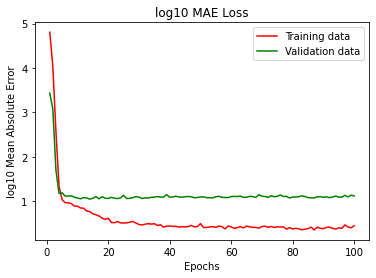

In [27]:
plt.figure()
plt.plot(range(1,101),train_mae_loss_list,'-r',label="Training data")
plt.plot(range(1,101),val_mae_loss_list,'-g',label="Validation data")
plt.gca().set_xlabel("Epochs")
plt.gca().set_ylabel("log10 Mean Absolute Error")
plt.gca().set_title("log10 MAE Loss")
plt.legend()

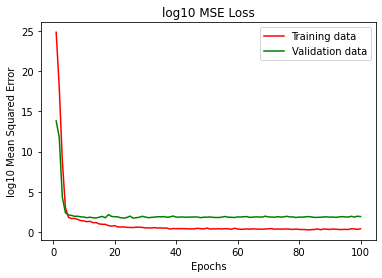

In [28]:
plt.figure()
plt.plot(range(1,101),train_mse_loss_list,'-r',label="Training data")
plt.plot(range(1,101),val_mse_loss_list,'-g',label="Validation data")
plt.gca().set_xlabel("Epochs")
plt.gca().set_ylabel("log10 Mean Squared Error")
plt.gca().set_title("log10 MSE Loss")
plt.legend()

In [29]:
def abs_err(x,y):
    return np.abs(x-y)
def reg_err(x,y):
    return x-y

In [43]:
# Evaluate training distribution
model.eval()
train_mae_loss = []
train_reg_loss = []
train_pred = []
train_label = []
for image, label in tqdm(train_loader,desc="Train data: "):
    # Send variables to device
    image = image.to(device)
    label = label.to(device)
    # Run model
    pred = model(image)
    # Move variables to cpu
    pred = pred.cpu().squeeze().detach()
    label = label.cpu().squeeze().detach()
#     print(pred.shape)
#     print(abs_err(pred,label))
    # Compute loss
    train_mae_loss = np.concatenate((train_mae_loss, abs_err(pred,label)))
    train_reg_loss = np.concatenate((train_reg_loss, reg_err(pred,label)))
    train_pred = np.concatenate((train_pred,pred))
    train_label = np.concatenate((train_label,label))

Train data: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:05<00:00,  9.33it/s]


Text(0.5, 0, 'log10 absolute error')

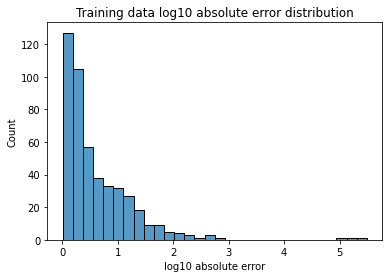

In [44]:
# Plot absolute error (log) distribution for model
sns.histplot(train_mae_loss)#, kde=True)
plt.gca().set_title("Training data log10 absolute error distribution")
plt.gca().set_xlabel("log10 absolute error")

Text(0.5, 0, 'log10 error')

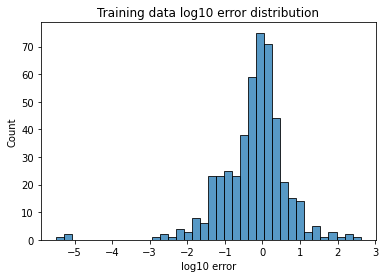

In [45]:
sns.histplot(train_reg_loss)#, kde=True)
plt.gca().set_title("Training data log10 error distribution")
plt.gca().set_xlabel("log10 error")

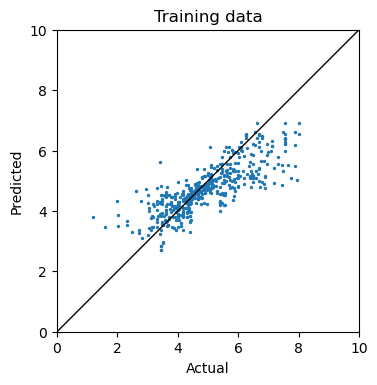

In [70]:
plt.figure(dpi=100)
plt.scatter(train_label,train_pred, s=2)
plt.gca().set_box_aspect(1)
plt.gca().set_xlim(0,10)
plt.gca().set_ylim(0,10)
plt.gca().set_xlabel("Actual")
plt.gca().set_ylabel("Predicted")
plt.gca().set_title("Training data")
xpoints = ypoints = plt.gca().get_xlim()
plt.gca().plot(xpoints, ypoints, linestyle='-', color='k', lw=1, scalex=False, scaley=False)

In [54]:
# Evaluate validation distribution
model.eval()
val_mae_loss = []
val_reg_loss = []
val_pred = []
val_label = []
for image, label in tqdm(val_loader,desc="Validation data: "):
    # Send variables to device
    image = image.to(device)
    label = label.to(device)
    # Run model
    pred = model(image)
    # Move variables to cpu
    pred = pred.cpu().squeeze().detach()
    label = label.cpu().squeeze().detach()
#     print(pred.shape)
#     print(abs_err(pred,label))
    # Compute loss
    val_mae_loss = np.concatenate((val_mae_loss, abs_err(pred,label)))
    val_reg_loss = np.concatenate((val_reg_loss, reg_err(pred,label)))
    val_pred = np.concatenate((val_pred,pred))
    val_label = np.concatenate((val_label,label))

Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Text(0.5, 0, 'log10 absolute error')

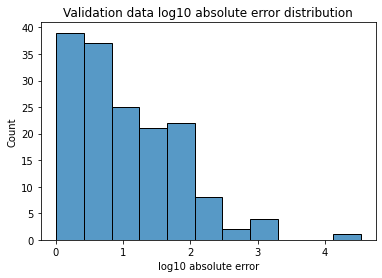

In [55]:
sns.histplot(val_mae_loss)
plt.gca().set_title("Validation data log10 absolute error distribution")
plt.gca().set_xlabel("log10 absolute error")

Text(0.5, 0, 'log10 error')

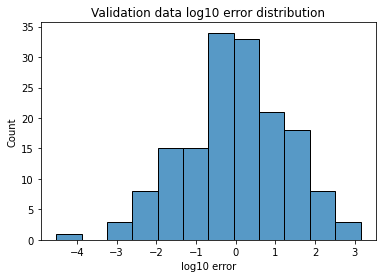

In [56]:
sns.histplot(val_reg_loss)
plt.gca().set_title("Validation data log10 error distribution")
plt.gca().set_xlabel("log10 error")

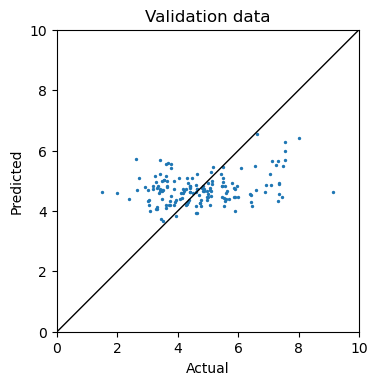

In [71]:
plt.figure(dpi=100)
plt.scatter(val_label, val_pred, s=2)
plt.gca().set_box_aspect(1)
plt.gca().set_xlim(0,10)
plt.gca().set_ylim(0,10)
plt.gca().set_xlabel("Actual")
plt.gca().set_ylabel("Predicted")
plt.gca().set_title("Validation data")
xpoints = ypoints = plt.gca().get_xlim()
plt.gca().plot(xpoints, ypoints, linestyle='-', color='k', lw=1, scalex=False, scaley=False)

In [66]:
# Evaluate test distribution
model.eval()
test_mae_loss = []
test_reg_loss = []
test_pred = []
test_label = []
for image, label in tqdm(test_loader,desc="Test data: "):
    # Send variables to device
    image = image.to(device)
    label = label.to(device)
    # Run model
    pred = model(image)
    # Move variables to cpu
    pred = pred.cpu().squeeze().detach()
    label = label.cpu().squeeze().detach()
#     print(pred.shape)
#     print(abs_err(pred,label))
    # Compute loss
    test_mae_loss = np.concatenate((test_mae_loss, abs_err(pred,label)))
    test_reg_loss = np.concatenate((test_reg_loss, reg_err(pred,label)))
    test_pred = np.concatenate((test_pred,pred))
    test_label = np.concatenate((test_label,label))

Test data: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Text(0.5, 0, 'log10 absolute error')

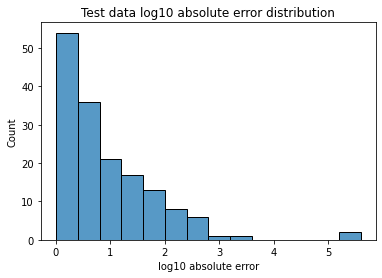

In [67]:
sns.histplot(test_mae_loss)
plt.gca().set_title("Test data log10 absolute error distribution")
plt.gca().set_xlabel("log10 absolute error")

Text(0.5, 0, 'log10 error')

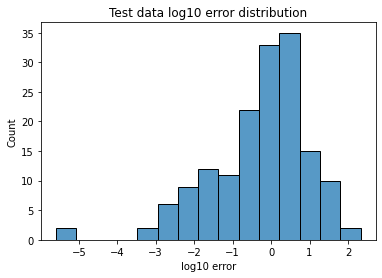

In [68]:
sns.histplot(test_reg_loss)
plt.gca().set_title("Test data log10 error distribution")
plt.gca().set_xlabel("log10 error")

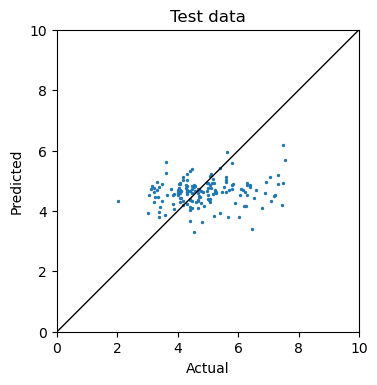

In [72]:
plt.figure(dpi=100)
plt.scatter(test_label, test_pred, s=2)
plt.gca().set_box_aspect(1)
plt.gca().set_xlim(0,10)
plt.gca().set_ylim(0,10)
plt.gca().set_xlabel("Actual")
plt.gca().set_ylabel("Predicted")
plt.gca().set_title("Test data")
xpoints = ypoints = plt.gca().get_xlim()
plt.gca().plot(xpoints, ypoints, linestyle='-', color='k', lw=1, scalex=False, scaley=False)